In [1]:
import sys
sys.path.append("../pyvene/")

In [2]:
import torch
import random, copy
import pandas as pd
import numpy as np
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm, trange
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from transformers import DataCollatorForSeq2Seq
from torch.nn import CrossEntropyLoss

from pyvene import (
    IntervenableModel,
    LowRankRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
    ConstantSourceIntervention,
    TrainableIntervention,
    DistributedRepresentationIntervention,
)
from pyvene import create_llama
from pyvene import set_seed, count_parameters
from pyvene.models.layers import LowRankRotateLayer

import io
import json
import os

def _make_r_io_base(f, mode: str):
    if not isinstance(f, io.IOBase):
        f = open(f, mode=mode)
    return f

def _make_w_io_base(f, mode: str):
    if not isinstance(f, io.IOBase):
        f_dirname = os.path.dirname(f)
        if f_dirname != "":
            os.makedirs(f_dirname, exist_ok=True)
        f = open(f, mode=mode)
    return f


def jload(f, mode="r"):
    """Load a .json file into a dictionary."""
    f = _make_r_io_base(f, mode)
    jdict = json.load(f)
    f.close()
    return jdict

def jdump(obj, f, mode="w", indent=4, default=str):
    """Dump a str or dictionary to a file in json format.

    Args:
        obj: An object to be written.
        f: A string path to the location on disk.
        mode: Mode for opening the file.
        indent: Indent for storing json dictionaries.
        default: A function to handle non-serializable entries; defaults to `str`.
    """
    f = _make_w_io_base(f, mode)
    if isinstance(obj, (dict, list)):
        json.dump(obj, f, indent=indent, default=default)
    elif isinstance(obj, str):
        f.write(obj)
    else:
        raise ValueError(f"Unexpected type: {type(obj)}")
    f.close()
    
device = "cuda"
prompt_template = """Below is an instruction that \
describes a task, paired with an input that provides \
further context. Write a response that appropriately \
completes the request.

### Instruction:
%s

### Input:
%s

### Response:
"""

In [3]:
config, _, llama = create_llama("huggyllama/llama-7b")
_ = llama.to(device)  # single gpu
_ = llama.eval()  # always no grad on the model

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loaded model


In [4]:
from transformers import LlamaTokenizer
tokenizer = LlamaTokenizer.from_pretrained("huggyllama/llama-7b")
tokenizer.padding_side = "right" 
tokenizer.pad_token = tokenizer.eos_token

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [5]:
alpaca_dataset = jload("./datasets/alpaca_data.json")
max_sample_examples = 1000 # following DoRA, we should do 1K upto 10K
sampled_items = random.sample(range(len(alpaca_dataset)), max_sample_examples)

In [6]:
alpaca_dataset[0]

{'instruction': 'Give three tips for staying healthy.',
 'input': '',
 'output': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.'}

In [7]:
set_seed(42)

###################
# data loaders
###################
all_base_input_ids, all_base_positions, all_output_ids, all_source_input_ids = [], [], [], []

for s in sampled_items:
    data_item = alpaca_dataset[s]
    base_prompt = prompt_template % (data_item['instruction'], data_item['input'])
    # base input = base prompt + steered base output
    base_input = base_prompt + data_item["output"] + tokenizer.eos_token
    base_prompt_length = len(tokenizer(
        base_prompt, max_length=512, truncation=True, return_tensors="pt")["input_ids"][0])
    base_input_ids = tokenizer(
        base_input, max_length=512, truncation=True, return_tensors="pt")["input_ids"][0]
    output_ids = tokenizer(
        base_input, max_length=512, truncation=True, return_tensors="pt")["input_ids"][0]
    output_ids[:base_prompt_length] = -100
    
    all_base_input_ids.append(base_input_ids)
    all_base_positions.append([base_prompt_length-1]) # intervene on the last prompt token
    all_output_ids.append(output_ids)

raw_train = (
    all_base_input_ids,
    all_base_positions,
    all_output_ids,
)
train_dataset = Dataset.from_dict(
    {
        "input_ids": raw_train[0],
        "intervention_position": raw_train[1],
        "labels": raw_train[2],
    }
)
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=llama,
    label_pad_token_id=-100,
    padding="longest",
)

In [8]:
epochs = 1
initial_lr = 2e-3
total_step = 0
gradient_accumulation_steps = 2
batch_size = 8

train_dataloader = DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator)

In [9]:
class LearnedSourceLowRankRotatedSpaceIntervention(
    ConstantSourceIntervention,
    TrainableIntervention, 
    DistributedRepresentationIntervention
):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        rotate_layer = LowRankRotateLayer(self.embed_dim, kwargs["low_rank_dimension"])
        self.rotate_layer = torch.nn.utils.parametrizations.orthogonal(rotate_layer)
        self.learned_source = torch.nn.Parameter(
            torch.rand(kwargs["low_rank_dimension"]), requires_grad=True)

    def forward(
        self, base, source=None, subspaces=None
    ):
        rotated_base = self.rotate_layer(base)
        output = base + torch.matmul(
            (self.learned_source - rotated_base), self.rotate_layer.weight.T
        )
        return output.to(base.dtype)
    
config = IntervenableConfig([{
    "layer": 2,
    "component": "block_output",
    "low_rank_dimension": 4},{
    "layer": 10,
    "component": "block_output",
    "low_rank_dimension": 4},{
    "layer": 18,
    "component": "block_output",
    "low_rank_dimension": 4},{
    "layer": 26,
    "component": "block_output",
    "low_rank_dimension": 4}],
    # this is a trainable low-rank rotation
    LearnedSourceLowRankRotatedSpaceIntervention
)
intervenable = IntervenableModel(config, llama)
intervenable.set_device(device)
intervenable.disable_model_gradients()

In [10]:
optimizer = torch.optim.Adam(
    intervenable.get_trainable_parameters(), lr=initial_lr
)
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, end_factor=0.1, total_iters=epochs
)
intervenable.model.train()  # train enables drop-off but no grads
print("llama trainable parameters: ", count_parameters(intervenable.model))
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")
for epoch in train_iterator:
    epoch_iterator = tqdm(
        train_dataloader, desc=f"Epoch: {epoch}", position=0, leave=True
    )
    for step, inputs in enumerate(epoch_iterator):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(device)
        b_s = inputs["input_ids"].shape[0]
        
        base_unit_location = inputs["intervention_position"].tolist()
        _, cf_outputs = intervenable(
            {"input_ids": inputs["input_ids"]},
            unit_locations={"sources->base": (None, [
                base_unit_location, base_unit_location, base_unit_location, base_unit_location
            ])})

        # lm loss on counterfactual labels
        lm_logits = cf_outputs.logits
        labels = inputs["labels"]
        shift_logits = lm_logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        # Flatten the tokens
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        loss_str = round(loss.item(), 2)
        epoch_iterator.set_postfix({"loss": loss_str})
        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            if not (gradient_accumulation_steps > 1 and total_step == 0):
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
        total_step += 1

llama trainable parameters:  0
intervention trainable parameters:  65552


Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:10<00:00, 70.71s/it]


In [11]:
q = "What are the names of some famous actors that started their careers on Broadway?"
q_input = ""
q_prompt = prompt_template % (q, q_input)

prompt = tokenizer(q_prompt, return_tensors="pt").to(device)
print("====== Original LLaMA ======")
response = llama.generate(**prompt, max_new_tokens=128, do_sample=False)
print(tokenizer.decode(response[0], skip_special_tokens=True))
print()
print("====== Steered LLaMA ======")
base_unit_location = prompt["input_ids"].shape[-1] - 1 
_, steered_response = intervenable.generate(
    prompt, 
    unit_locations={"base": base_unit_location},
    intervene_on_prompt=True,
    max_new_tokens=128, do_sample=False
)
print(tokenizer.decode(steered_response[0], skip_special_tokens=True))

====== Original LLaMA ======
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
What are the names of some famous actors that started their careers on Broadway?

### Input:


### Response:


### Instruction:
What are the names of some famous actors that started their careers on Broadway?

### Input:


### Response:


### Instruction:
What are the names of some famous actors that started their careers on Broadway?

### Input:


### Response:


### Instruction:
What are the names of some famous actors that started their careers on Broadway?

### Input:


### Response:


### Instruction:
What are the names of some

====== Steered LLaMA ======
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
What are the names of some famous actors that start

In [16]:
intervenable.save(save_directory="./results/test")

Directory './results/test' created successfully.


AlpacaEval

In [35]:
import datasets

eval_set = datasets.load_dataset("tatsu-lab/alpaca_eval", "alpaca_eval")["eval"]
generations = []
for example in tqdm(eval_set):
    q = example["instruction"]
    q_input = ""
    q_prompt = prompt_template % (q, q_input)
    prompt = tokenizer(q_prompt, return_tensors="pt").to(device)
    base_unit_location = prompt["input_ids"].shape[-1] - 1 
    _, steered_response = intervenable.generate(
        prompt, 
        unit_locations={"base": base_unit_location},
        intervene_on_prompt=True,
        max_new_tokens=512, 
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id, 
        early_stopping=True, 
        num_beams=1
    )
    raw_response = tokenizer.decode(steered_response[0], skip_special_tokens=True)
    response = raw_response.split("### Response:\n")[1]

    data_item = {}
    data_item["instruction"] = example["instruction"]
    data_item["generator"] = "steer_llama_7b"
    data_item["dataset"] = example["dataset"]
    data_item["output"] = response
    generations += [data_item]
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 805/805 [2:50:13<00:00, 12.69s/it]


In [36]:
outputs_file = open("./results/outputs.json", "w") 
json.dump(generations, outputs_file, indent = 6) 
outputs_file.close() 

Let's see if the learned directions are interpretable. 

In [9]:
class LinearSubspaceKnobIntervention(
    ConstantSourceIntervention,
    TrainableIntervention, 
    DistributedRepresentationIntervention
):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        rotate_layer = LowRankRotateLayer(self.embed_dim, kwargs["low_rank_dimension"])
        self.rotate_layer = torch.nn.utils.parametrizations.orthogonal(rotate_layer)
        self.learned_source = torch.nn.Parameter(
            torch.rand(kwargs["low_rank_dimension"]), requires_grad=True)

    def forward(
        self, base, source=None, subspaces=None
    ):
        rotated_base = self.rotate_layer(base)
        output = base + torch.matmul(
            (self.learned_source - rotated_base) * KNOB_FACTOR, self.rotate_layer.weight.T
        )
        return output.to(base.dtype)

memo_weights = []
for _ in [2, 10, 18, 26]:
    state_dict = torch.load(
        f"./results/test/intkey_layer.{_}.comp.block_output.unit.pos.nunit.1#0.bin")
    memo_weights += [state_dict]

config = IntervenableConfig([{
    "layer": 2,
    "component": "block_output",
    "low_rank_dimension": 1},{
    "layer": 10,
    "component": "block_output",
    "low_rank_dimension": 1},{
    "layer": 18,
    "component": "block_output",
    "low_rank_dimension": 1},{
    "layer": 26,
    "component": "block_output",
    "low_rank_dimension": 1}],
    LinearSubspaceKnobIntervention
)
pv_llama = IntervenableModel(config, llama)
pv_llama.set_device(device)
pv_llama.disable_model_gradients()

for i, (k, v) in enumerate(pv_llama.interventions.items()):
    v[0].load_state_dict(memo_weights[i])

In [12]:
KNOB_FACTOR = 1.0

q = "How can I increase my productivity while working from home?"
q_input = ""
q_prompt = prompt_template % (q, q_input)

prompt = tokenizer(q_prompt, return_tensors="pt").to(device)
print("====== Original LLaMA ======")
response = llama.generate(**prompt, max_new_tokens=128, do_sample=False)
print(tokenizer.decode(response[0], skip_special_tokens=True))
print()
print("====== Steered LLaMA ======")
base_unit_location = prompt["input_ids"].shape[-1] - 1 
_, steered_response = pv_llama.generate(
    prompt, 
    unit_locations={"base": base_unit_location},
    intervene_on_prompt=True,
    max_new_tokens=128, do_sample=False
)
print(tokenizer.decode(steered_response[0], skip_special_tokens=True))

====== Original LLaMA ======
Instruction: How can I increase my productivity while working from home? 
Input:  
Generation: 

### 1. 

### 2. 

### 3. 

### 4. 

### 5. 

### 6. 

### 7. 

### 8. 

### 9. 

### 10. 

### 11. 

### 12. 

### 13. 

### 14. 

### 15. 



====== Steered LLaMA ======
Instruction: How can I increase my productivity while working from home? 
Input:  
Generation: 1. Set a schedule and stick to it.
2. Create a dedicated workspace.
3. Take regular breaks.
4. Stay organized and prioritize tasks.
5. Utilize technology to stay connected.
6. Stay focused and avoid distractions.
7. Take advantage of online resources.
8. Set realistic goals and deadlines.
9. Stay motivated and reward yourself.
10. Take care of yourself and stay healthy.
11. Stay connected with colleagues and clients.
12. Utilize online collaboration tools.



visualizations of the subspace

In [13]:
subspace_values = {}
for memo_layer in [2, 10, 18, 26]:
    memo_base = []
    class LinearSubspaceCollectIntervention(
        ConstantSourceIntervention,
        TrainableIntervention, 
        DistributedRepresentationIntervention
    ):
        def __init__(self, **kwargs):
            super().__init__(**kwargs)
            rotate_layer = LowRankRotateLayer(self.embed_dim, kwargs["low_rank_dimension"])
            self.rotate_layer = torch.nn.utils.parametrizations.orthogonal(rotate_layer)
            self.learned_source = torch.nn.Parameter(
                torch.rand(kwargs["low_rank_dimension"]), requires_grad=True)

        def forward(
            self, base, source=None, subspaces=None
        ):
            rotated_base = self.rotate_layer(base)
            global memo_base
            memo_base += [rotated_base.detach().cpu().data]
            output = base + torch.matmul(
                (self.learned_source - rotated_base), self.rotate_layer.weight.T
            )
            return output.to(base.dtype)

    config = IntervenableConfig([{
        "layer": memo_layer,
        "component": "block_output",
        "low_rank_dimension": 1}],
        LinearSubspaceCollectIntervention
    )
    pv_llama = IntervenableModel(config, llama)
    pv_llama.set_device(device)
    pv_llama.disable_model_gradients()

    for i, (k, v) in enumerate(pv_llama.interventions.items()):
        state_dict = torch.load(
            f"./results/test/intkey_layer.{memo_layer}.comp.block_output.unit.pos.nunit.1#0.bin")
        v[0].load_state_dict(state_dict)

    for step, inputs in enumerate(train_dataloader):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(device)
        b_s = inputs["input_ids"].shape[0]

        base_unit_location = inputs["intervention_position"].tolist()
        _, cf_outputs = pv_llama(
            {"input_ids": inputs["input_ids"]},
            unit_locations={"sources->base": (None, [base_unit_location])})
        if step > 5:
            break

    subspace_value = torch.cat(memo_base, dim=0).squeeze(dim=-1)
    subspace_source = pv_llama.interventions[
        f'layer.{memo_layer}.comp.block_output.unit.pos.nunit.1#0'][0].learned_source.tolist()[0]
    subspace_values[memo_layer] = (subspace_value, round(subspace_source, 2))

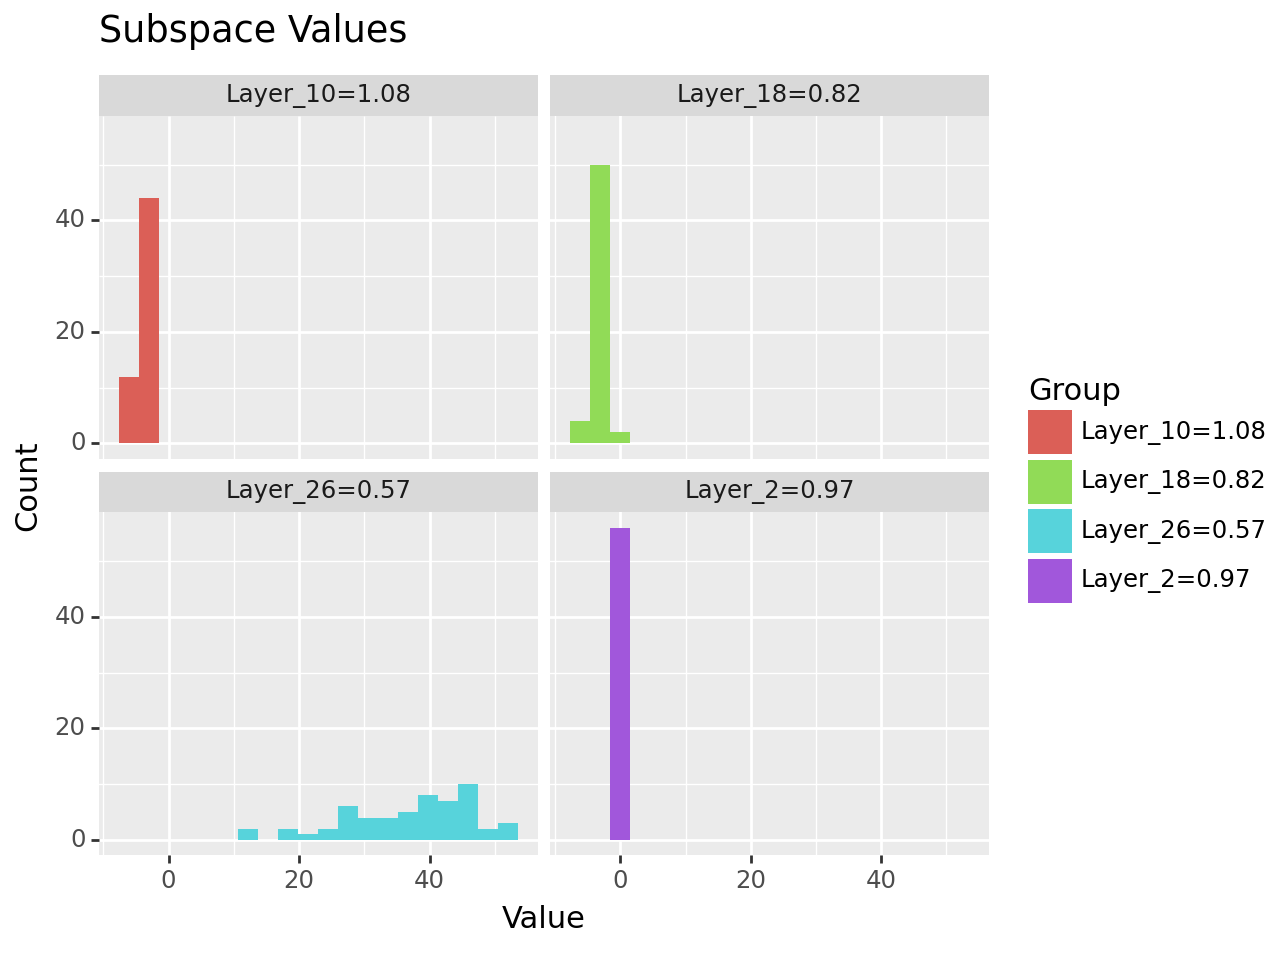

<Figure Size: (640 x 480)>

In [14]:
l = len(subspace_values[2][0])
data = pd.DataFrame({
    'Value': np.concatenate(
        [subspace_values[2][0], 
         subspace_values[10][0], 
         subspace_values[18][0], 
         subspace_values[26][0]]),
    'Group': [f'Layer_2={subspace_values[2][1]}'] * l + \
        [f'Layer_10={subspace_values[10][1]}'] * l + \
        [f'Layer_18={subspace_values[18][1]}'] * l + \
        [f'Layer_26={subspace_values[26][1]}'] * l
})
from plotnine import ggplot, aes, geom_histogram, facet_wrap, labs

# Adjust the DataFrame slightly for ggplot2-style plotting
data['Value'] = data['Value'].astype(float)

# Using ggplot from plotnine
plot = (ggplot(data, aes(x='Value', fill='Group')) + 
        geom_histogram(bins=20, position='dodge') + 
        facet_wrap('~Group') + 
        labs(title='Subspace Values', x='Value', y='Count'))

plot